In [171]:
import pickle
import random

from keyrover import *
from keyrover.homography import *

'mps'

In [ ]:
with open("blender/camera_data.bin", "rb") as f:
    camera_data = pickle.load(f)

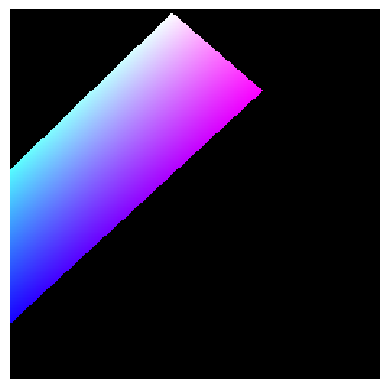

In [185]:
i = random.randint(0, len(camera_data["location"]))
location = camera_data["location"][i]
rotation = camera_data["rotation"][i]

# prediction format: [[alpha, beta, gamma, x, y, z], ... (batches)]
prediction = torch.tensor([[*rotation, *location]],
                          requires_grad=True, device=device, dtype=torch.float32)

texcoords = prediction_to_texture_coordinates(prediction)

t = texcoords[0]
t[2] += 1
t[2] /= t[2].max() / 2
t[2] -= 1

imshow(t)